**Classification on Fasion Mnist using PyTorch**
1. Loading the data set
2. Preprocessing the dataset
3. Definition of Neural Network
4. Training a Neural Network
5. Testing a Neural Network

#**Loading the pakages**

In [39]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


#**Loading and visualize data**

In [41]:
# Define a transform to convert images to tensors and normalize them
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5), )])


# Load the data: train and test sets

trainset = datasets.FashionMNIST('-/.pytorch/F_MNIST_data', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('-/.pytorch/F_MNIST_data', download = True, train = False, transform = transform)


# Preparing for validation test
indices = list(range(len(trainset)))
np.random.shuffle(indices)

#  to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])



In [42]:
# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle = True)

In [43]:
trainset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: -/.pytorch/F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

#**Visualize a Batch of Training Data**

In [44]:
trainloader

#**Visualize the Data**

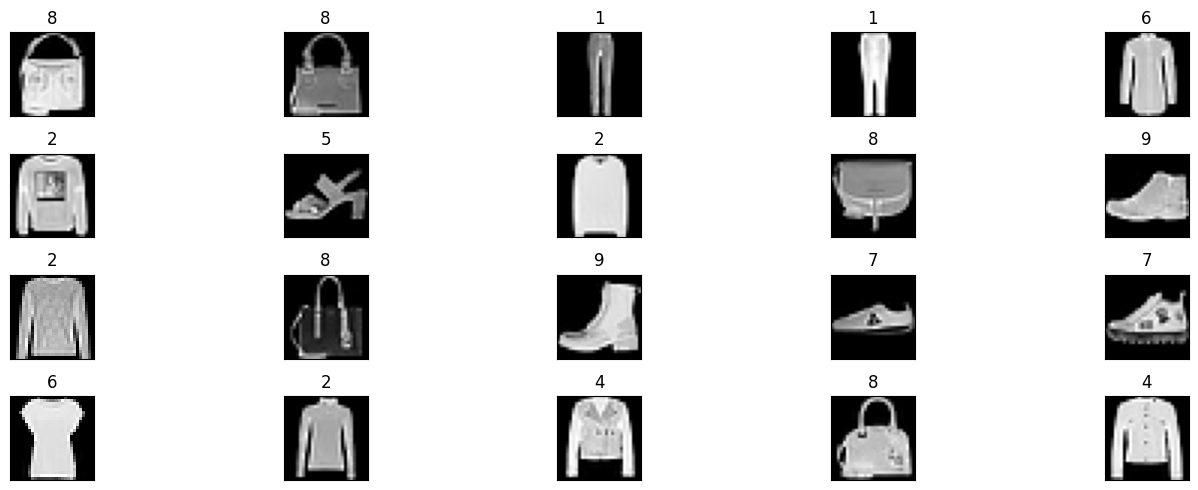

In [45]:
# create an interior for a trainloader
dataiter = iter(trainloader)
print(dataiter)


# get the next batch of data (images and lables)
images, lables = next(dataiter)

# create a figure to display the images
fig = plt.figure(figsize=(15,5))

# Loop through the first 20 images in the batch
for idx in np.arange(20):
  # create a subplot for each image
  ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])

  # display the images using a grayscale colormap
  ax.imshow(np.squeeze(images[idx]), cmap='gray')


  ax.set_title(lables[idx].item())

fig.tight_layout()

#**Define the Neural Network**

In [46]:
# Define a custom classifier class that inherits from nn.Modules

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    # Define the layers of the Neural Network
    self.fc1 = nn.Linear(784, 120)
    self.fc2 = nn.Linear(120, 120)
    self.fc3 = nn.Linear(120, 10)
    self.dropout = nn.Dropout(0.2)


  def forward(self, x):
    # reshape the input tensor to have a flat vector shape
    x = x.view(x.shape[0], -1)

    # apply the first fully connected layer with relu activation and dropout
    x = self.dropout(F.relu(self.fc1(x)))

    # apply the second fully connected layer with relu activation and dropout
    x = self.dropout(F.relu(self.fc2(x)))

    # apply the 3rd fully connected layer with relu activation and dropout
    x = F.log_softmax(self.fc3(x), dim = 1)

    return x

#**Training the Model**

In [37]:
model = Classifier()

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

valid_loss_min = np.Inf

epochs = 20

steps = 0

model.train()

train_losses, valid_losses = [], []

for e in range(epochs):
    running_loss = 0
    valid_loss = 0

    # train the model
    for images, labels in trainloader:
        optimizer.zero_grad()
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    # validate the model
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for images, labels in validloader:
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            valid_loss += loss.item() * images.size(0)

    # calculate the average loss
    running_loss = running_loss / len(trainloader.dataset)
    valid_loss = valid_loss / len(validloader.dataset)

    train_losses.append(running_loss)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e + 1,
        running_loss,
        valid_loss
    ))

    # Save the model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

    model.train()  # Set the model back to training mode


Epoch: 1 	Training Loss: 0.379163 	Validation Loss: 0.266182
Validation loss decreased (inf --> 0.266182). Saving model ...
Epoch: 2 	Training Loss: 0.228424 	Validation Loss: 0.174521
Validation loss decreased (0.266182 --> 0.174521). Saving model ...
Epoch: 3 	Training Loss: 0.176779 	Validation Loss: 0.144813
Validation loss decreased (0.174521 --> 0.144813). Saving model ...
Epoch: 4 	Training Loss: 0.156070 	Validation Loss: 0.132558
Validation loss decreased (0.144813 --> 0.132558). Saving model ...
Epoch: 5 	Training Loss: 0.144590 	Validation Loss: 0.125026
Validation loss decreased (0.132558 --> 0.125026). Saving model ...
Epoch: 6 	Training Loss: 0.137049 	Validation Loss: 0.118073
Validation loss decreased (0.125026 --> 0.118073). Saving model ...
Epoch: 7 	Training Loss: 0.131208 	Validation Loss: 0.115304
Validation loss decreased (0.118073 --> 0.115304). Saving model ...
Epoch: 8 	Training Loss: 0.125430 	Validation Loss: 0.110251
Validation loss decreased (0.115304 --> 0

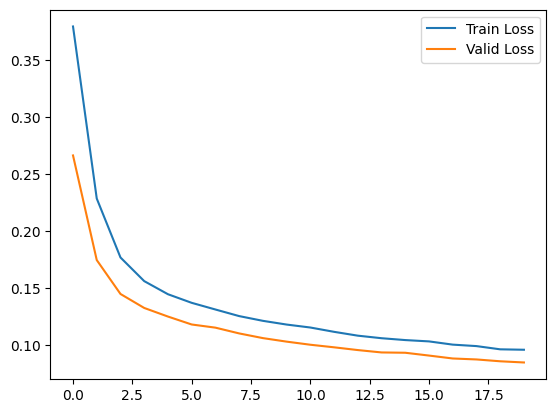

In [38]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(valid_losses, label = 'Valid Loss')

plt.legend()

#**Testing the model**

In [48]:
# Track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
for images, labels in testloader:
  # forward pass
  output = model(images)
  # calculate the loss
  loss = criterion(output, labels)
  # update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to the true labels
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

  # calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# calculate the print test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))




Test Loss: 0.486347

Test Accuracy of     0: 81% (815/1000)
Test Accuracy of     1: 94% (946/1000)
Test Accuracy of     2: 77% (770/1000)
Test Accuracy of     3: 87% (872/1000)
Test Accuracy of     4: 73% (739/1000)
Test Accuracy of     5: 86% (865/1000)
Test Accuracy of     6: 44% (445/1000)
Test Accuracy of     7: 91% (918/1000)
Test Accuracy of     8: 93% (932/1000)
Test Accuracy of     9: 92% (929/1000)

Test Accuracy (overall): 82% (8231/10000)


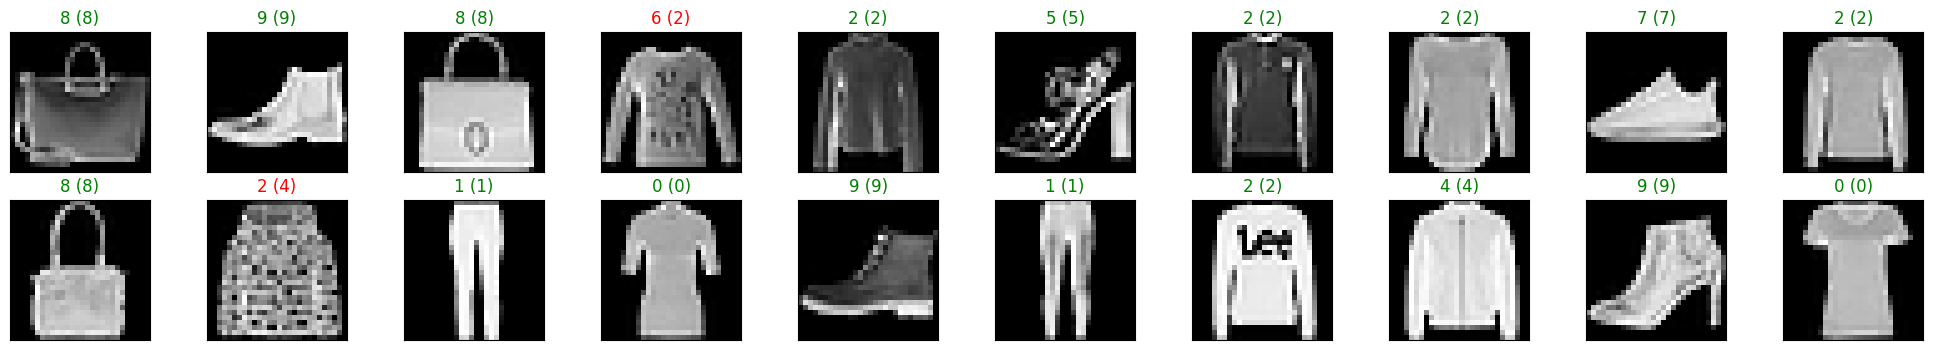

In [49]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images =  images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap = 'gray')
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
               color="green" if preds[idx] == labels[idx] else "red")
